<a href="https://www.kaggle.com/code/vaishakgkumar/generating-fake-faces-using-gan?scriptVersionId=129594945" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
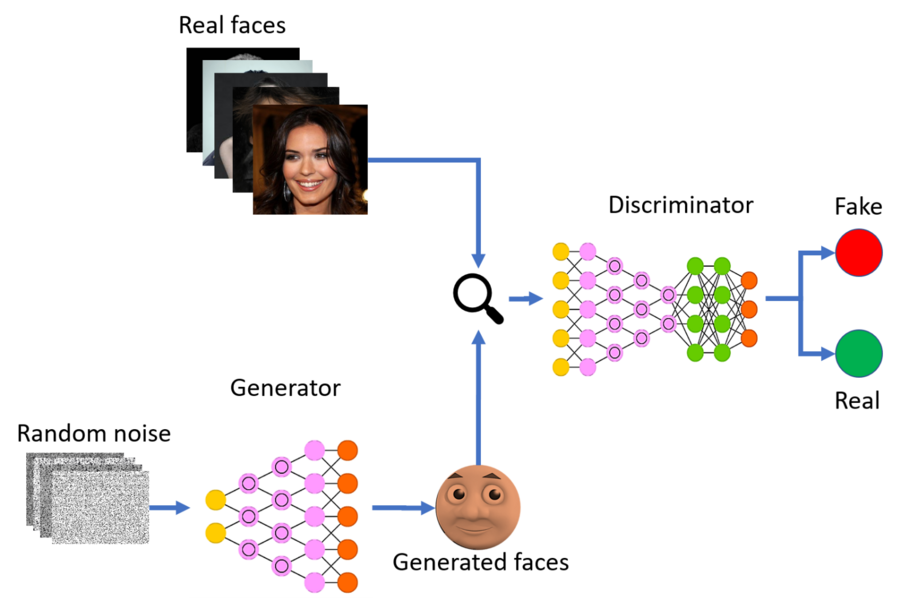

Generative Adversarial Networks (GANs) are generative models. They are uses unsupervised technique to generate new things. GAN models learns pattern in input data in such a way that they can generate new sample which resemble with the input data. The main aim of generative adversarial network is to match generated distribution with the original data distribution.

GANs are an exciting and rapidly changing field, delivering generative models ability to generate realistic examples across a range of problem domains, most notably in image-to-image translation tasks such as translating photos of summer to winter or day to night,coloring images and in generating fake photos that even human cannot categorized as fake image.
This <a href = 'https://thispersondoesnotexist.com/'> site </a> uses GAN to generate fake human faces which are similar to real human

### Components of GANs
<b> Generator </b>: Generator are neural network that learns to generate data which resemble with the input distribution. The generator model take fixed dimension random vector from Gaussian distribution as input and generate the sample out of it which resemble with input.

<b> Discriminator </b>: Discriminator are simple neural network that distinguish fake and real data.The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake.

Generative adversarial networks are based on a game theoretic scenario in which the generator network must compete against an adversary. The generator network directly produces samples. Its adversary, the discriminator network, attempts to distinguish between samples drawn from the training data and samples drawn from the generator.

# Working of GANs
![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11000153/g1.jpg)

First of all we take batch of random vector from the Gaussian distribution and generate fake image out of it using generator. Since generator isn't trained so generated image donot resemble with the real input distribution. We take batches of image from the input distribution along with generated fake images and fed it to discriminator so that it learns to distinguish between real and fake images.
Now, after training discriminator, we take the batch of images that generator generated and fed them through discriminator again (here we donot fed real images), discriminator will provide an output probabilities, these values are then compared with the probability that the generator should generated (ie 1), error is calculated and backpropagated through the generator and the weight are updated.
This above process is repeated until generated images resemble with the input distribution.

## Application of GANs

## 1. Generating fake faces
![image.png](https://lh3.googleusercontent.com/e1uW26Fr2APReggNw8xgcgpbWYHqh6RTjRBSSWpEkumHJa85KWLHFzFcP9kfOnrpt7iL6k7p8N0JezthCQtv_hWo8u6IukPZSy6xael-OI29S59MXDwrPJfkPH2IljWF9EGf5VRU=s0)

## 2. Generate Examples for Image Datasets
![image.png](https://machinelearningmastery.com/wp-content/uploads/2019/04/Examples-of-GANs-used-to-Generate-New-Plausible-Examples-for-Image-Datasets-1024x719.png)

## 3. Face Aging
![3](http://www.baycare.net/media/5076/botox-aging-face-plastic-surgery.jpg)

## 4. Super Resolution
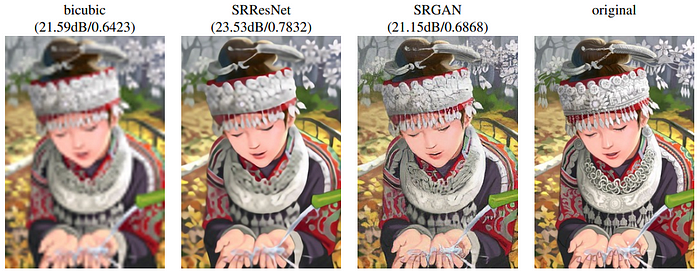

# **Objective: To generate fake faces of human**

## Generative Adversial Network (GAN) Architecture

![6](https://www.researchgate.net/publication/339100419/figure/fig4/AS:855933731213318@1581081912316/The-architecture-of-the-first-GAN-network-a-the-generator-and-b-the-discriminator.ppm)

# **Import necessary Libraries**

In [ ]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

# **Load data**
Here I have used face-mask-lite-dataset, out of available 10000 images i have only use 9090 image. I have read image using opencv since opencv reads image in bgr format i have converted it back to rgb format using cvtColor function. These images are resize into 128 by 128 using resize function and are finally converted to array and are appended in empty array

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '../input/face-mask-lite-dataset/without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed9090.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

# **Visailze our images**
**plot_images()** that takes an integer argument called sqr. The function creates a figure with a size of 10 by 10 inches and a title of "Real Images". The function then loops over the range of sqr * sqr. For each iteration, the function creates a subplot of size sqr by sqr and plots the image at index i of the array _img. The function then sets the x- and y-ticks to empty.

**This code can be used to plot a grid of images. The grid can be used to visualize a large number of images at once.**

In [ ]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)
    

Here, i have defined batch size so that these batches of images can be fed directly to the discriminator network

In [ ]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

# **Generator**
Here, we have defined generator network. It take random vector from normal distribution as input. This random vector is passed through dense layer and is reshaped and is finally fed through Convolution layers. Here, convolution layers does downsampling of our latent vector, after series of convolution batch normalization and leakyrelu layer our downsampled latent vector is upsampled using Conv2DTranspose.

The final output layer of Generator generate 128 by 128 by 3 image. The final layer of generator uses hyperbolic tangent as activation to squash the value in between -1 and 1. Generator model looks like simple autoencoder model, where input data is downsampled first and is finally upsampled .

In [ ]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [ ]:
generator = Generator()
generator.summary()

# **Discriminator**
Here, discriminator model take 128 by 128 by 3 image that can be real or generated. This input image is downsampled using Convolution layer and is finally flattened and is fed to single neuron so that it can distinguish real and fake image. Since, final layer uses sigmoid function as activation, it output value in between 0 and 1. Here value greater than 0.5 refers to real and less than 0.5 refers to fake image. The output of discriminator is used in training of generator.

In [ ]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  


In [ ]:
discriminator = Discriminator()
discriminator.summary()

# **Let's plot image generated by generator before training**
**generates a random noise vector** and passes it to the generator model. The generator model then generates an image from the noise vector. The image is then plotted using the imshow() function.

**This code can be used to generate new images from random noise.**

In [ ]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

# **Defining loss function and optimizer**

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

# **Defining training steps**

In [ ]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

# **Function to plot generated images**
defines a function called **plot_generated_images()** that takes two integer arguments called square and epochs. The function creates a figure with a size of 10 by 10 inches. The function then loops over the range of square * square. For each iteration, the function creates a subplot of size square by square and plots the image generated by the generator model at index i of the array noise. T**he function then sets the x- and y-ticks to empty and adds a grid.**

If the **epochs argument is not equal to 0**, the function also adds a title to the figure that shows the number of epochs.

This code can be used to plot a grid of generated images.

In [ ]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [ ]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))
            
        
        
    

# **Training**

In [ ]:

train(5,dataset)


# **Some Generated Images**


In [ ]:
plot_generated_images(1)

In [ ]:
plot_generated_images(2)

In [ ]:
plot_generated_images(5)

In [ ]:
plot_generated_images(7)

# **Saving The Trained Model**
Saves the generator and discriminator models to the files **generator.h5** and **discriminator.h5**. The generator.h5 file contains the weights and biases of the generator model, while the discriminator.h5 file contains the weights and biases of the discriminator model.

These files can be loaded later to use the models again. For example, you could load the models to continue training them, or you could load the models to use them in a different project.

In [ ]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")

# **EVALUATION**

The code loads two pre-trained models, a generator and a discriminator, from the working directory. The **generator** is a model that can create new images, while the **discriminator** is a model that can distinguish between real and fake images.

**The code then generates a new image using the generator. The generated image is then passed to the discriminator, which tries to determine whether the image is real or fake. The code then prints the output of the discriminator, which is a number between 0 and 1. A value of 0 means that the discriminator believes the image is real, while a value of 1 means that the discriminator believes the image is fake.**

This code can be used to evaluate the performance of the generator and the discriminator. For example, you could use this code to see how well the generator can create images that are indistinguishable from real images. You could also use this code to see how well the discriminator can distinguish between real and fake images.

From my perspective, this code is interesting because it shows how two different models can be used to create and evaluate synthetic images. This is an important area of research, as it has the potential to be used to create new forms of art, entertainment, and education.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

generator = load_model('/kaggle/working/generator.h5')
discriminator = load_model('/kaggle/working/discriminator.h5')

noise = tf.random.normal(shape=(1, 100))
generated_image = generator(noise)

discriminator_output = discriminator(generated_image)
print(discriminator_output)

# **Fake Faces Generation**

The code loads a pre-trained generator model from the generator.h5 file. The generator model is a deep learning model that can be used to create new images.

* The code then generates a batch of 100 images. Each image is created by passing a random noise vector to the generator model.

* The code then converts the generated images to uint8 format, which is a format that can be displayed on a computer screen.

* The code then creates a directory to store the generated images. If the directory does not already exist, the code creates it.

* The code then saves the generated images to files in the generated_images directory. The name of each file is the index of the image in the batch.

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# Load the generator model.
generator = tf.keras.models.load_model('generator.h5')

# Generate a batch of noise.
noise = np.random.normal(size=(100, 100))

# Generate a batch of images.
generated_images = generator.predict(noise)

# Convert the generated images to uint8 format.
generated_images_uint8 = np.uint8((generated_images + 1.0) / 2.0 * 255.0)

# Create a directory to store the generated images.
directory = 'generated_images'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the generated images to files.
for i in range(100):
    image = Image.fromarray(generated_images_uint8[i])
    image.save(f'{directory}/{i}.png')


# **Download The Generated Images**
Creates a zip file of the generated images. The zip file is created in the current directory and is named generated_images.zip. The code then uses the FileLink function to download the zip file to the user's computer.

In [ ]:
import shutil
import os

# Create the zip file
shutil.make_archive('generated_images', 'zip', 'generated_images')

# Download the zip file
from IPython.display import FileLink
FileLink(r'generated_images.zip')
